In [1]:
!pip install --q pandas
!pip install --q scanpy
!pip install --q palantir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 806.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.1 MB/s eta

In [23]:
import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [3]:
data_dir = os.path.expanduser("./")
download_url = "https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad"
file_path = os.path.join(data_dir, "marrow_sample_scseq_counts.h5ad")
ad = sc.read(file_path, backup_url=download_url)
ad

  0%|          | 0.00/69.9M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 4142 × 16106



---

# Normalization

In [4]:
sc.pp.normalize_per_cell(ad)

In [5]:
palantir.preprocess.log_transform(ad)



---

# Highly variable gene selection

In [6]:
sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor="cell_ranger")



---

# PCA

In [7]:
sc.pp.pca(ad)

In [8]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'



---

# Diffusion maps

In [9]:
dm_res = palantir.utils.run_diffusion_maps(ad, n_components=5)

In [10]:
ms_data = palantir.utils.determine_multiscale_space(ad)



---

# Visualization

In [11]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

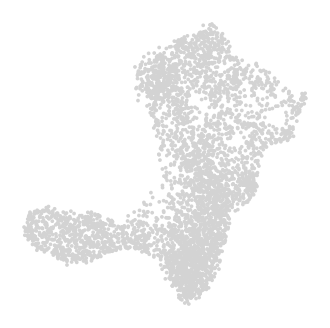

In [12]:
sc.pl.embedding(
    ad,
    basis="umap",
    frameon=False,
)



---
# MAGIC imputation


In [13]:
imputed_X = palantir.utils.run_magic_imputation(ad)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


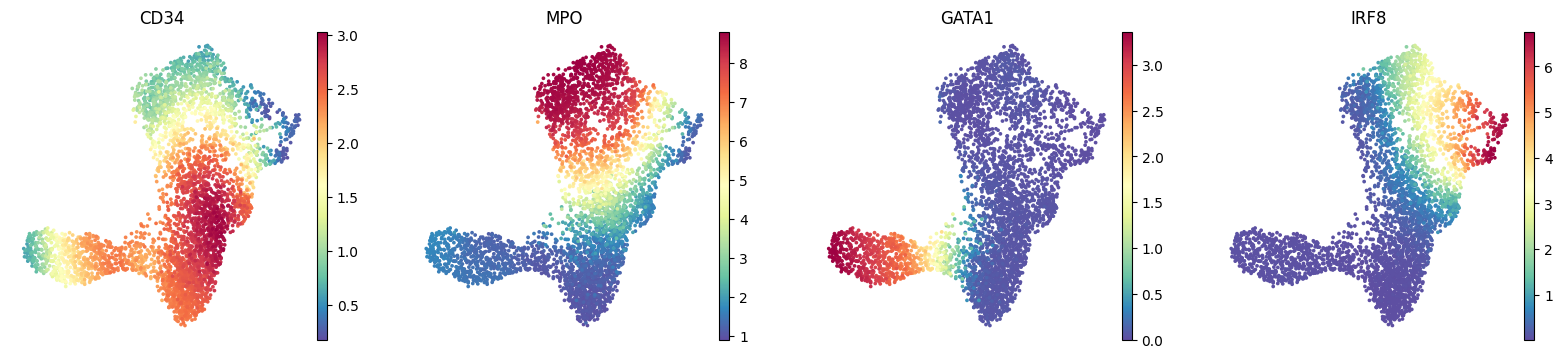

In [14]:
sc.pl.embedding(
    ad,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CD34", "MPO", "GATA1", "IRF8"],
    frameon=False,
)
plt.show()



---

# Diffusion maps visualization


(<Figure size 1500x300 with 5 Axes>,
 {0: <Axes: title={'center': 'Component 0'}>,
  1: <Axes: title={'center': 'Component 1'}>,
  2: <Axes: title={'center': 'Component 2'}>,
  3: <Axes: title={'center': 'Component 3'}>,
  4: <Axes: title={'center': 'Component 4'}>})

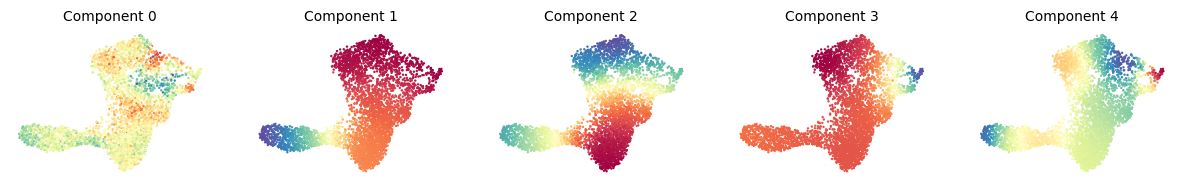

In [15]:
palantir.plot.plot_diffusion_components(ad)

In [16]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'DM_EigenValues', 'neighbors', 'umap'
    obsm: 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'distances', 'connectivities'

In [17]:
print(ad.obs_names)

Index(['Run4_120703408880541', 'Run4_120703409056541', 'Run4_120703409580963',
       'Run4_120703423990708', 'Run4_120703436876077', 'Run4_120726912355038',
       'Run4_120726924974443', 'Run4_120726924978030', 'Run4_120726943295348',
       'Run4_120726943845302',
       ...
       'Run5_241057700113179', 'Run5_241098858613659', 'Run5_241098858810213',
       'Run5_241098873552118', 'Run5_241098885647774', 'Run5_241098904976174',
       'Run5_241106375007076', 'Run5_241114577000174', 'Run5_241114577004764',
       'Run5_241114589051630'],
      dtype='object', length=4142)


In [25]:
terminal_states = pd.Series(
    ["DC", "Mono", "Ery"],
    index=["Run5_131097901611291", "Run5_134936662236454", "Run4_200562869397916"],
)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

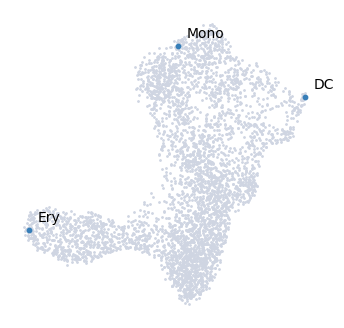

In [26]:
palantir.plot.highlight_cells_on_umap(ad, terminal_states)

In [27]:
start_cell = "Run5_164698952452459"
pr_res = palantir.core.run_palantir(
    ad, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.01129927635192871 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Time for shortest paths: 0.3642955501874288 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


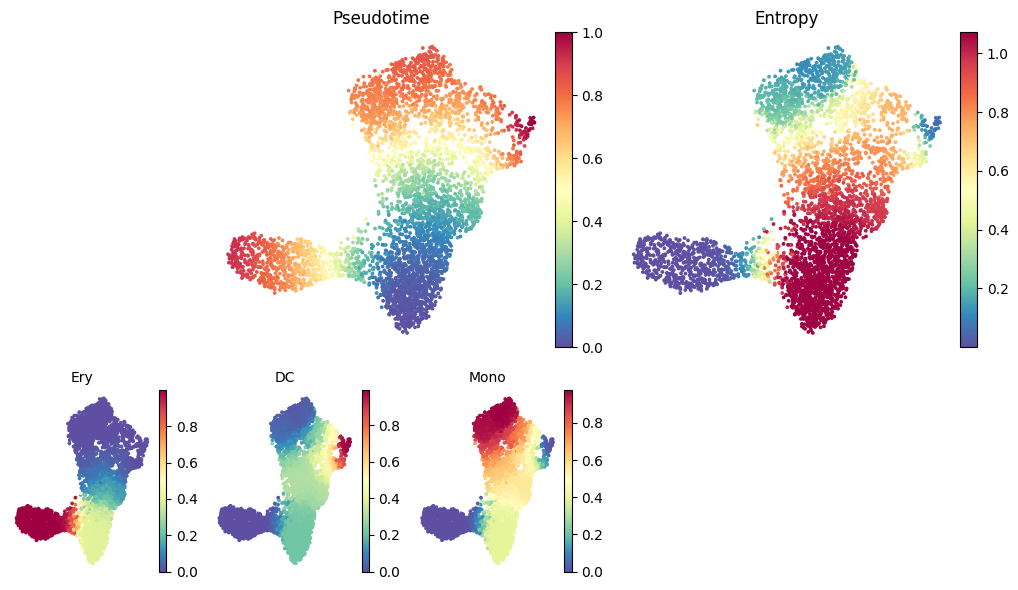

In [29]:
palantir.plot.plot_palantir_results(ad, s=3)
plt.show()

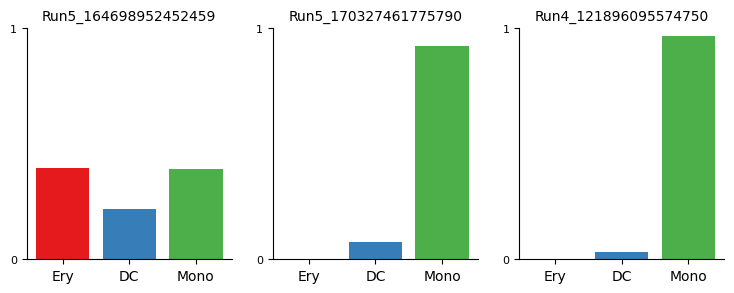

In [30]:
cells = [
    "Run5_164698952452459",
    "Run5_170327461775790",
    "Run4_121896095574750",
]
palantir.plot.plot_terminal_state_probs(ad, cells)
plt.show()

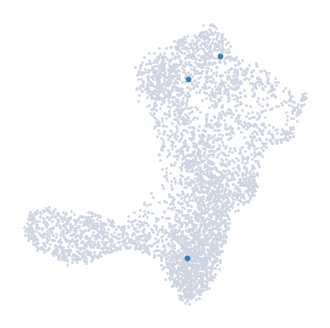

In [31]:
palantir.plot.highlight_cells_on_umap(ad, cells)
plt.show()



---

# Gene expression trends

In [32]:
masks = palantir.presults.select_branch_cells(ad, q=.01, eps=.01)

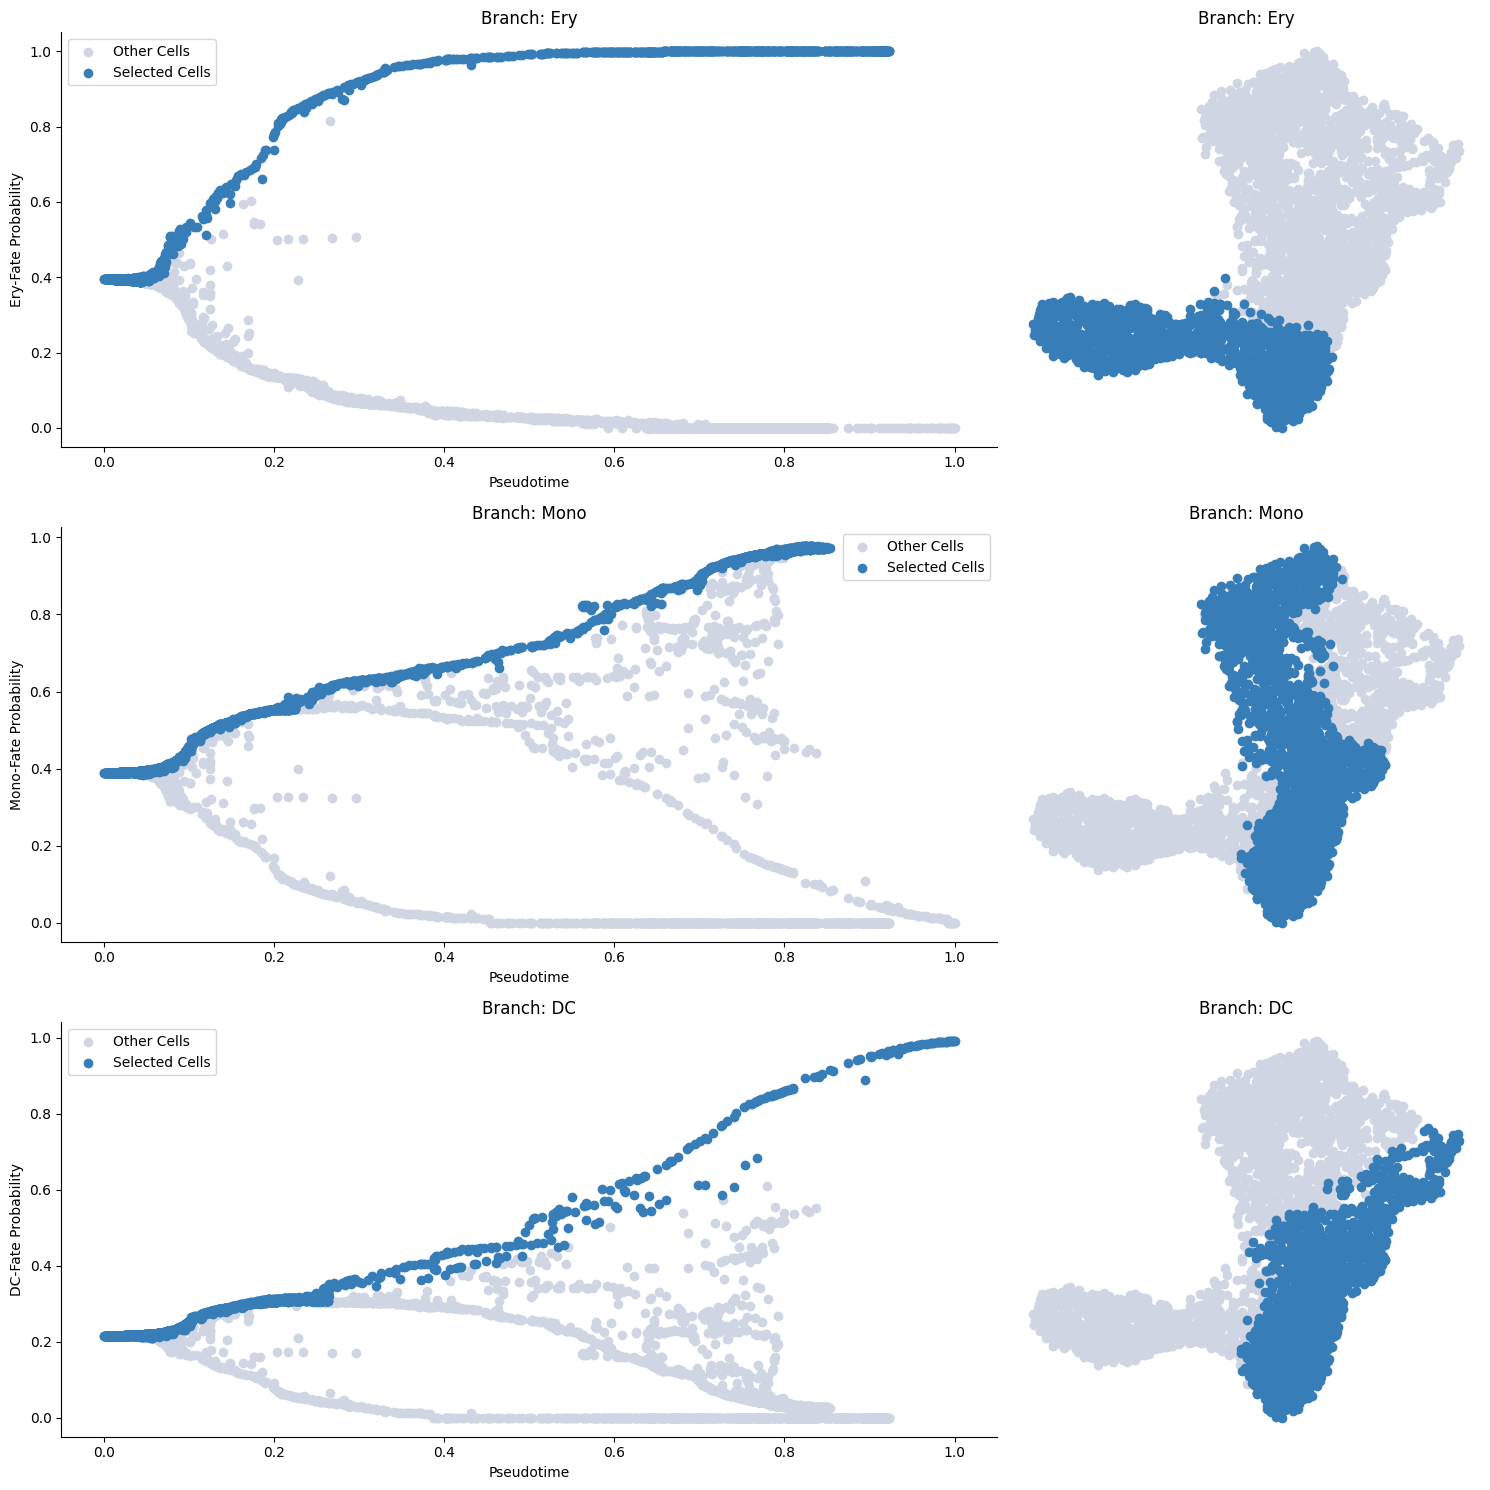

In [33]:
palantir.plot.plot_branch_selection(ad)
plt.show()

[2024-06-26 04:31:38,027] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (1,566) and rank = 1.0.
[2024-06-26 04:31:38,034] [INFO    ] Using covariance function Matern52(ls=1.0799293518066406).
[2024-06-26 04:31:38,041] [INFO    ] Computing 50 landmarks with k-means clustering.


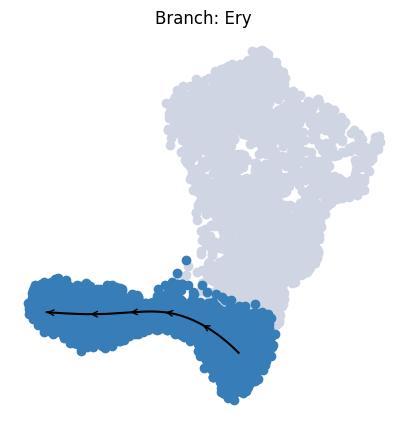

In [35]:
palantir.plot.plot_trajectory(ad, "Ery")
plt.show()

[2024-06-26 04:33:30,576] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (1,566) and rank = 1.0.
[2024-06-26 04:33:30,586] [INFO    ] Using covariance function Matern52(ls=1.0799293518066406).
[2024-06-26 04:33:30,589] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: Ery'}, xlabel='UMAP1', ylabel='UMAP2'>

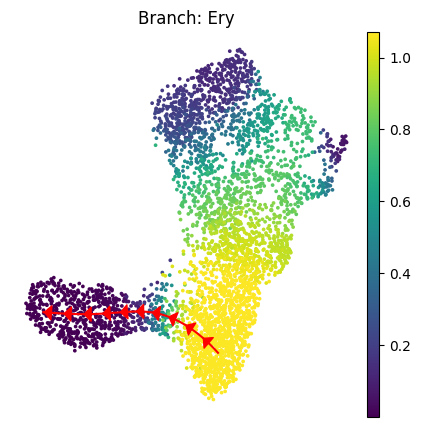

In [37]:
palantir.plot.plot_trajectory(
    ad,
    "Ery",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)

In [38]:
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    expression_key="MAGIC_imputed_data",
)

Ery
[2024-06-26 04:35:02,529] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,566) and rank = 1.0.
[2024-06-26 04:35:02,541] [INFO    ] Using covariance function Matern52(ls=1.0).
DC
[2024-06-26 04:35:13,286] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,912) and rank = 1.0.
[2024-06-26 04:35:13,289] [INFO    ] Using covariance function Matern52(ls=1.0).
Mono
[2024-06-26 04:35:23,372] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (2,592) and rank = 1.0.
[2024-06-26 04:35:23,373] [INFO    ] Using covariance function Matern52(ls=1.0).


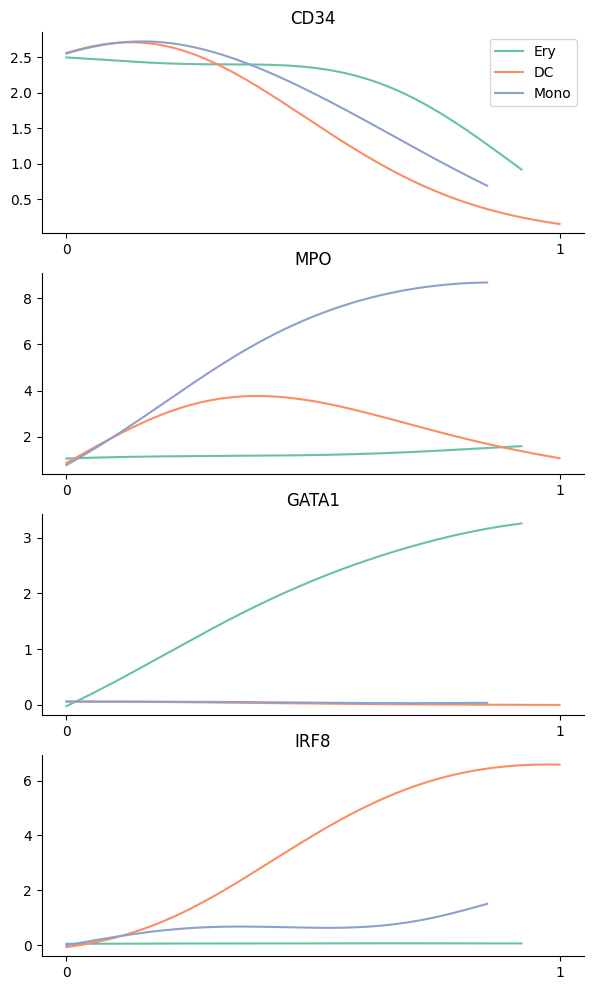

In [39]:
genes = ["CD34", "MPO", "GATA1", "IRF8"]
palantir.plot.plot_gene_trends(ad, genes)
plt.show()

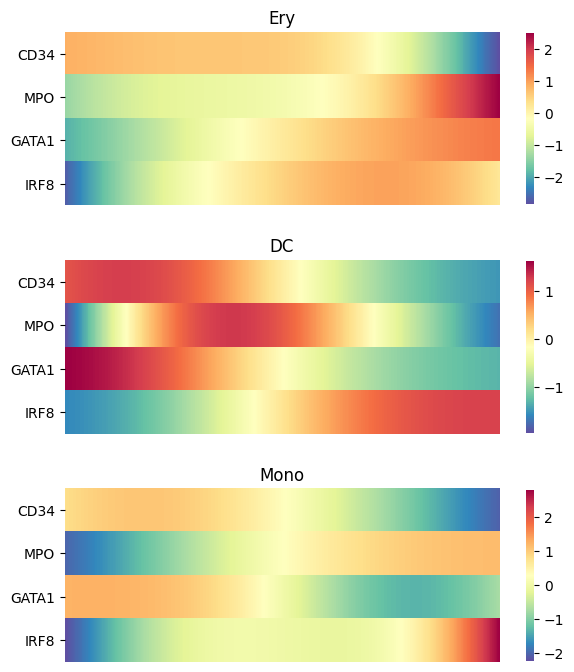

In [40]:
palantir.plot.plot_gene_trend_heatmaps(ad, genes)
plt.show()

In [41]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts', 'palantir_pseudotime', 'palantir_entropy'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'DM_EigenValues', 'neighbors', 'umap', 'palantir_waypoints'
    obsm: 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_umap', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs', 'gene_trends_Ery', 'gene_trends_DC', 'gene_trends_Mono'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'distances', 'connectivities'

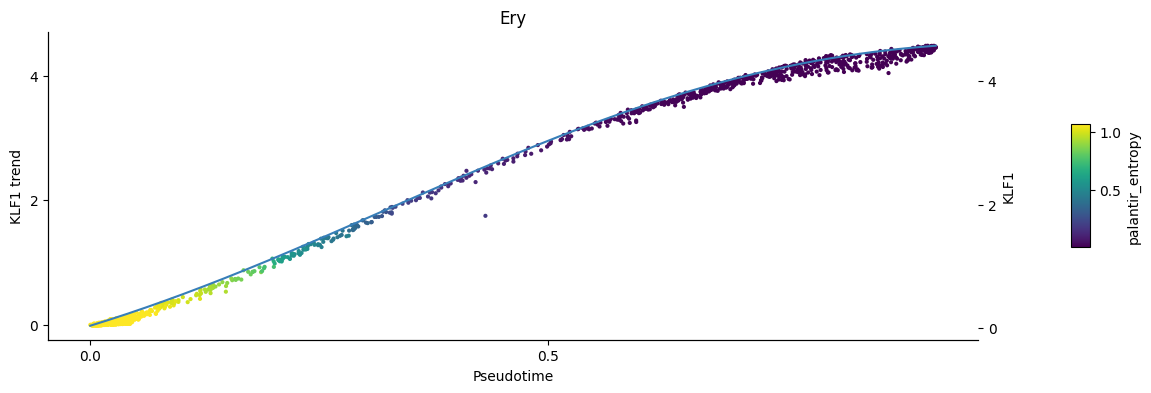

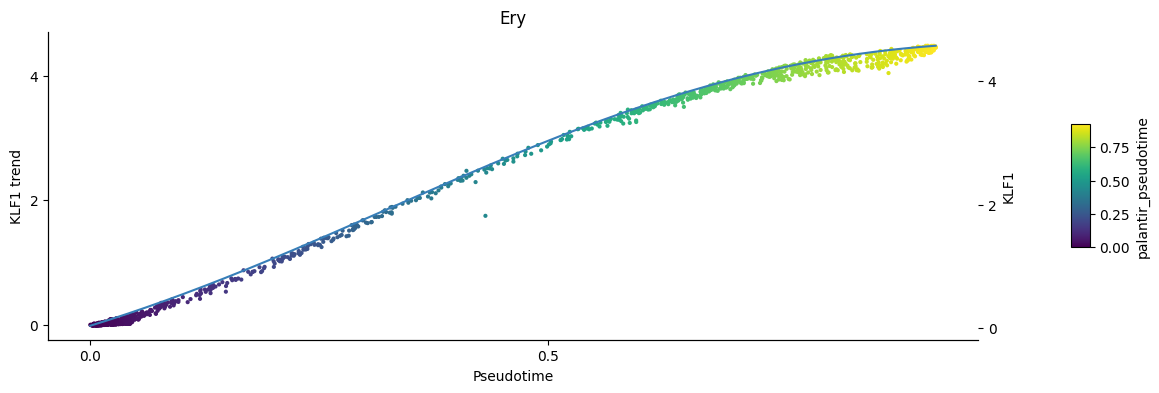

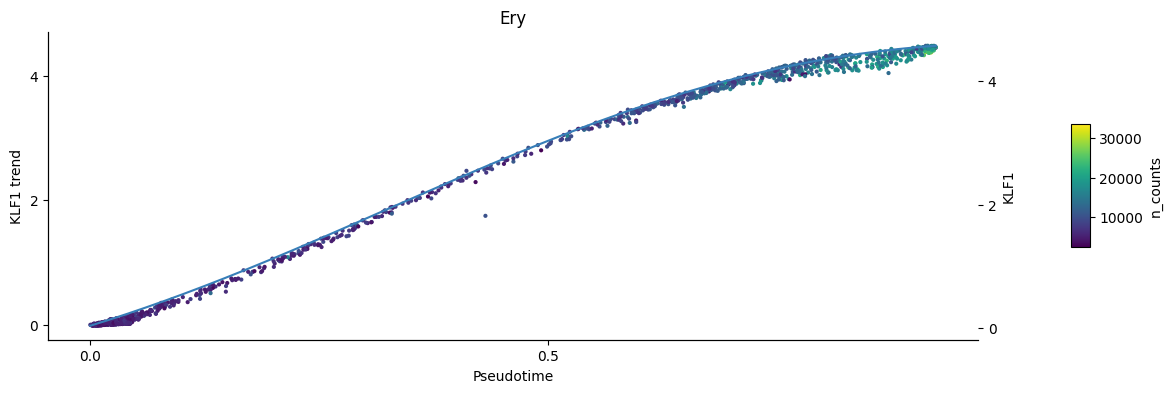

In [47]:
palantir.plot.plot_trend(ad, "Ery", "KLF1", color="palantir_entropy", position_layer="MAGIC_imputed_data")
palantir.plot.plot_trend(ad, "Ery", "KLF1", color="palantir_pseudotime", position_layer="MAGIC_imputed_data")
palantir.plot.plot_trend(ad, "Ery", "KLF1", color="n_counts", position_layer="MAGIC_imputed_data")
plt.show()

In [48]:
more_genes = ad.var_names[:1000]
communities = palantir.presults.cluster_gene_trends(ad, "Ery", more_genes)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/palantir/presults.py:481: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(gt_ad, **kwargs)


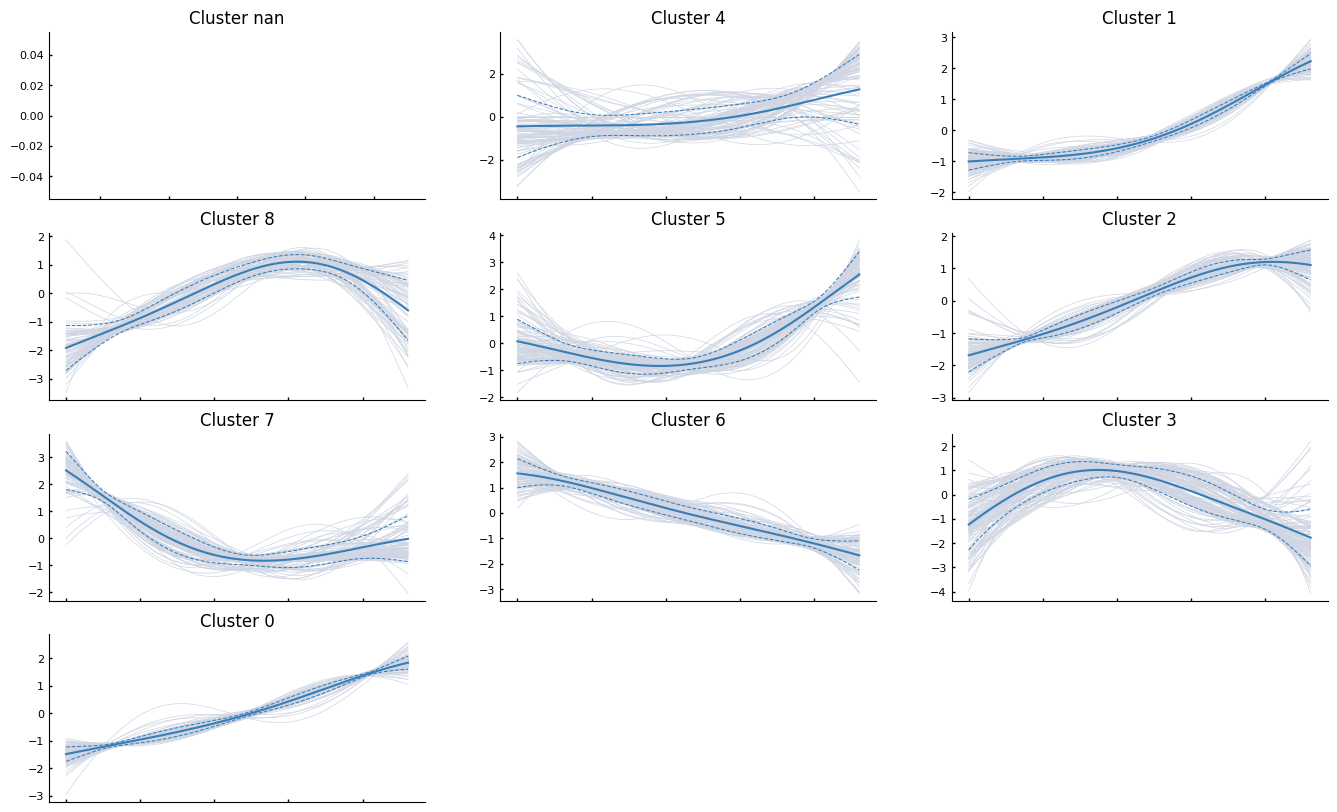

In [49]:
palantir.plot.plot_gene_trend_clusters(ad, "Ery")
plt.show()

In [50]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts', 'palantir_pseudotime', 'palantir_entropy'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_trends_clusters'
    uns: 'hvg', 'pca', 'DM_EigenValues', 'neighbors', 'umap', 'palantir_waypoints'
    obsm: 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_umap', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs', 'gene_trends_Ery', 'gene_trends_DC', 'gene_trends_Mono'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'distances', 'connectivities'